In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import statsmodels.api as sm

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from scipy import stats


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**LOADING DATAFRAMES**

In [3]:
# carregando dataset
train =pd.read_csv("/content/drive/MyDrive/MESTRADO/CMP Aprendizado de Máquina/TRABALHO/DADOS ESSE/train_data (1).csv")
val =pd.read_csv("/content/drive/MyDrive/MESTRADO/CMP Aprendizado de Máquina/TRABALHO/DADOS ESSE/val_data (1).csv")
test = pd.read_csv("/content/drive/MyDrive/MESTRADO/CMP Aprendizado de Máquina/TRABALHO/DADOS ESSE/test_data (1).csv")


**DIVINDINDO TREINO, TESTE E VALIDAÇAO EM ATRIBUTOS (X) E TARGET (Y)**

In [4]:
# dividindo em treino e teste para treinamento do modelo
X_train = train.drop(['patient_id','date','label'], axis=1)
y_train = train['label']

X_val = val.drop(['patient_id','date','label'], axis=1)
y_val = val['label']

X_test = test.drop(['patient_id','date','label'], axis=1)
y_test = test['label']

SMOTE DADOS TREINO

In [5]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
# Verificar a distribuição original da classe minoritária nos dados de treino
print(f"Distribuição original dos dados de treino: {Counter(y_train)}")

Distribuição original dos dados de treino: Counter({0: 1844, 1: 161})


In [6]:

# Instanciar o SMOTE
smote = SMOTE(random_state=42)
# Aplicar o SMOTE aos dados de treino
# O método fit_resample gera novas amostras sintéticas para a classe minoritária
X_res, y_res = smote.fit_resample(X_train, y_train)

In [7]:
# 4. Verificar a nova distribuição dos dados após a aplicação do SMOTE
print(f"Distribuição após SMOTE: {Counter(y_res)}")

Distribuição após SMOTE: Counter({1: 1844, 0: 1844})


**PARAMETROS PARA OTIMIZACAO RANDOMIZEDSEARCH**

In [8]:
# Redefine the hyperparameter distribution for the Logistic Regression model
# Ensure all parameter values are lists or distributions
param_distributions = [
    # l1 penalty
    {'penalty': ['l1'], 'solver': ['liblinear'], 'C': stats.uniform(0.0001, 100.0), 'max_iter': [10000]},
    {'penalty': ['l1'], 'solver': ['saga'], 'C': stats.uniform(0.0001, 100.0), 'l1_ratio': stats.uniform(0, 1), 'max_iter': [10000]},

    # l2 penalty
    {'penalty': ['l2'], 'solver': ['newton-cg'], 'C': stats.uniform(0.0001, 100.0), 'max_iter': [10000]},
    {'penalty': ['l2'], 'solver': ['lbfgs'], 'C': stats.uniform(0.0001, 100.0), 'max_iter': [10000]},
    {'penalty': ['l2'], 'solver': ['liblinear'], 'C': stats.uniform(0.0001, 100.0), 'max_iter': [10000]},
    {'penalty': ['l2'], 'solver': ['sag'], 'C': stats.uniform(0.0001, 100.0), 'max_iter': [10000]},
    {'penalty': ['l2'], 'solver': ['saga'], 'C': stats.uniform(0.0001, 100.0), 'max_iter': [10000]},

    # elasticnet penalty (only with saga)
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': stats.uniform(0.0001, 100.0), 'l1_ratio': stats.uniform(0, 1), 'max_iter': [10000]},

    # None penalty
    {'penalty': [None], 'solver': ['newton-cg'], 'max_iter': [10000]},
    {'penalty': [None], 'solver': ['lbfgs'], 'max_iter': [10000]},
    {'penalty': [None], 'solver': ['sag'], 'max_iter': [10000]},
    {'penalty': [None], 'solver': ['saga'], 'max_iter': [10000]},
]


RANDOM_STATE = 42
n_iter = 50
tscv = TimeSeriesSplit(n_splits=5)

**DEFININDO MODELO**

In [9]:
model = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)

from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Pipeline
#pipeline = Pipeline([
#    ('smote', SMOTE(random_state=RANDOM_STATE)), # Add SMOTE step
#    ("rl", LogisticRegression (class_weight='balanced',random_state=RANDOM_STATE, n_jobs=-1))
#])

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}


In [10]:
# 1. Instantiate a Logistic Regression model
model = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)

In [11]:
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=n_iter, # Use the defined number of iterations
    cv=tscv, # Use the TimeSeriesSplit for inner cross-validation
    scoring=scoring, # Use the dictionary of scoring metrics
    refit='f1', # Refit the model based on the F1 score
    random_state=RANDOM_STATE,
    n_jobs=-1,
    return_train_score=True # Keep train scores for analysis
)

**INSTANCIANDO**

In [12]:
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=n_iter, # Use the defined number of iterations
    cv=tscv, # Use the TimeSeriesSplit for inner cross-validation
    scoring=scoring, # Use the dictionary of scoring metrics
    refit='f1', # Refit the model based on the F1 score
    random_state=RANDOM_STATE,
    n_jobs=-1,
    return_train_score=True # Keep train scores for analysis
)

**FIT DO MODELO**

In [13]:
search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LogisticRegression(class_weight='balanced',
                                                n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ebdc8376330>,
                                         'max_iter': [10000], 'penalty': ['l1'],
                                         'solver': ['libline...
                   random_state=42, refit='f1', return_train_score=True,
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f1': make_scorer(f1_score, response_method='predict', zero_division=0),
                            'precision': make_scorer(precision_score, response_method='predict', zero_division=0),
                            'recall': make_scorer(recall_score, response_method='predict', zero_division=0)})

**GUARDANDO MELHORES PARAMETROS**

In [14]:
best_model_fold = search.best_estimator_

print("Best hyperparameters found in this fold:", search.best_params_)
print("Best F1 score on inner CV:", search.best_score_)

Best hyperparameters found in this fold: {'C': np.float64(3.4389521115218398), 'l1_ratio': np.float64(0.9093204020787821), 'max_iter': 10000, 'penalty': 'elasticnet', 'solver': 'saga'}
Best F1 score on inner CV: 0.2559912316785382


**AVALIANDO O MODELO NO CONJUNTO VALIDACAO**


-------------------------------------------- Avaliação no validation -------------------------------------------

Accuracy: 0.7678571428571429

Classification report:
               precision    recall  f1-score   support

           0     0.9837    0.7658    0.8612       316
           1     0.1778    0.8000    0.2909        20

    accuracy                         0.7679       336
   macro avg     0.5808    0.7829    0.5761       336
weighted avg     0.9358    0.7679    0.8273       336

Confusion matrix:
 [[242  74]
 [  4  16]]

ROC AUC: 0.8814873417721518


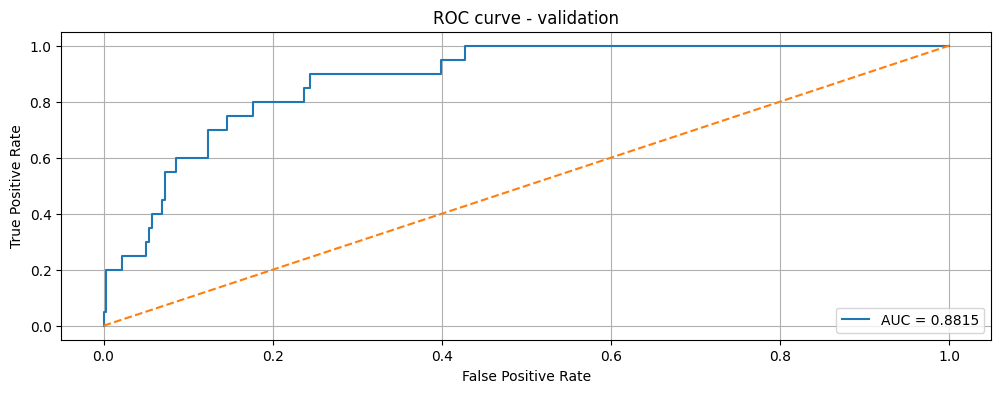

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate(model, X, y, set_name="set"):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    acc = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, digits=4)
    cm = confusion_matrix(y, y_pred)

    print(f"\n-------------------------------------------- Avaliação no {set_name} -------------------------------------------\n")
    print("Accuracy:", acc)
    print("\nClassification report:\n", report)
    print("Confusion matrix:\n", cm)

    unique_classes = np.unique(y)
    if len(unique_classes) == 2 and y_proba is not None:
        auc = roc_auc_score(y, y_proba)
        print("\nROC AUC:", auc)
        fpr, tpr, thr = roc_curve(y, y_proba)
        plt.figure(figsize=(12, 4))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
        plt.plot([0,1],[0,1],"--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC curve - {set_name}")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    return {"accuracy": acc, "report_str": report, "confusion_matrix": cm}

res_val = evaluate(best_model_fold, X_val, y_val, set_name="validation")

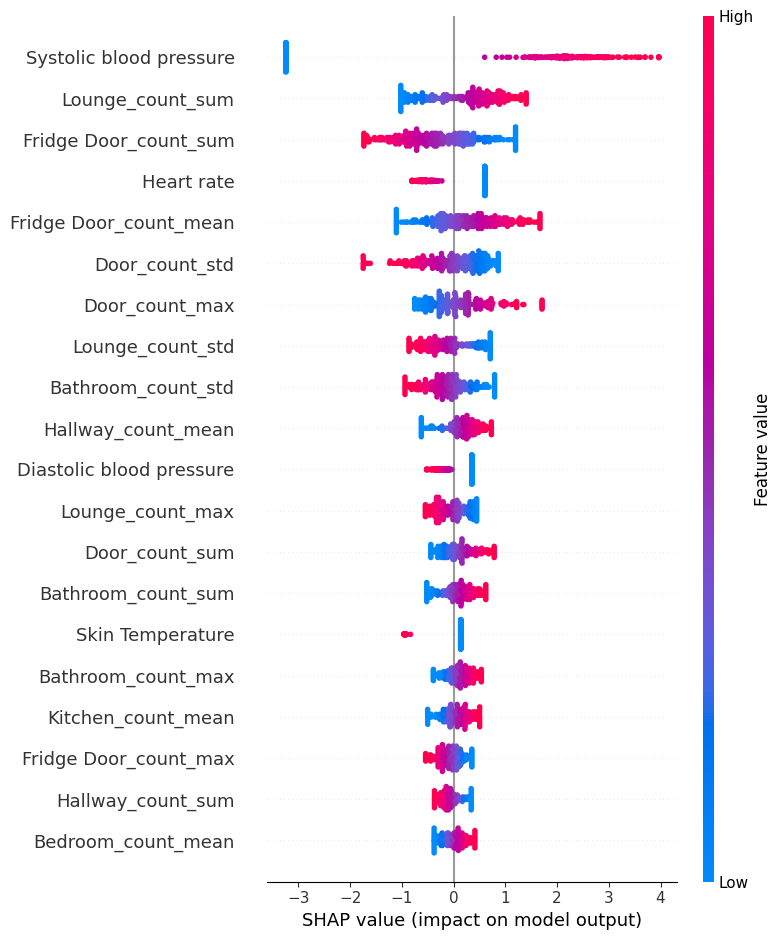

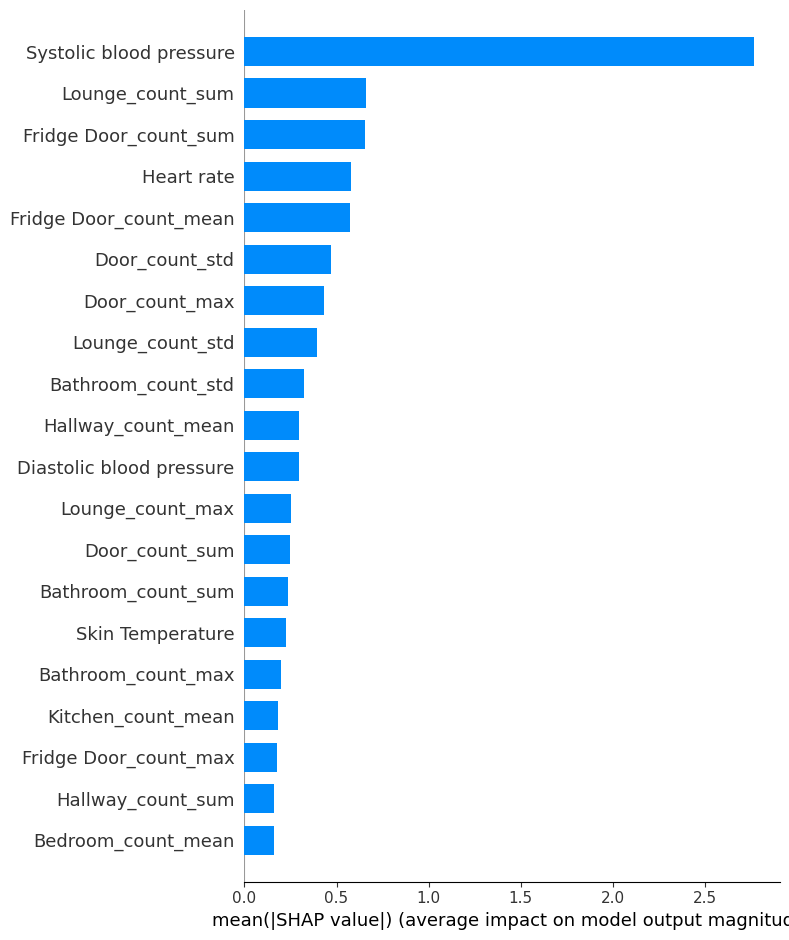

In [20]:
# Amostragem para reduzir custo computacional
import shap
bg = shap.sample(X_train, 100, random_state=42)  # background (100 exemplos)
X_sample = X_val.sample(n=min(300, len(X_val)), random_state=42)  # amostra de explicação

# Criação do LinearExplainer (suitable for linear models like Logistic Regression)
explainer = shap.LinearExplainer(
    best_model_fold.named_steps['rl'] if hasattr(best_model_fold, 'named_steps') else best_model_fold,
    masker=shap.maskers.Independent(data=bg), # Add the masker argument
    model_output="probability"
)

# Cálculo dos valores SHAP
shap_values = explainer.shap_values(X_sample)

# Summary plot
plt.figure()
shap.summary_plot(shap_values, X_sample, show=False)
plt.tight_layout()
plt.show()

# Bar plot
plt.figure()
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

**TREINANDO O MODELO NO CONJUNTO TREINO + VALIDACAO E AVALIANDO NO CONJUNTO TESTE**

In [22]:
# Concatenate train and validation sets
X_train_val = pd.concat([X_train, X_val], ignore_index=True)
y_train_val = pd.concat([y_train, y_val], ignore_index=True)

# Aplicar SMOTE no conjunto X_train_val
X_train_val_res, y_train_val_res = smote.fit_resample(X_train_val, y_train_val)

search.fit(X_train_val_test, y_train_val_test)
best_model_fold = search.best_estimator_

print("Best hyperparameters found in this fold:", search.best_params_)
print("Best F1 score on inner CV:", search.best_score_)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Best hyperparameters found in this fold: {'C': np.float64(1.563740674119393), 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 score on inner CV: 0.2687679809666815



-------------------------------------------- Avaliação no test + validation -------------------------------------------

Accuracy: 0.6307692307692307

Classification report:
               precision    recall  f1-score   support

           0     0.9657    0.5844    0.7282       385
           1     0.2793    0.8857    0.4247        70

    accuracy                         0.6308       455
   macro avg     0.6225    0.7351    0.5764       455
weighted avg     0.8601    0.6308    0.6815       455

Confusion matrix:
 [[225 160]
 [  8  62]]

ROC AUC: 0.8626345083487941


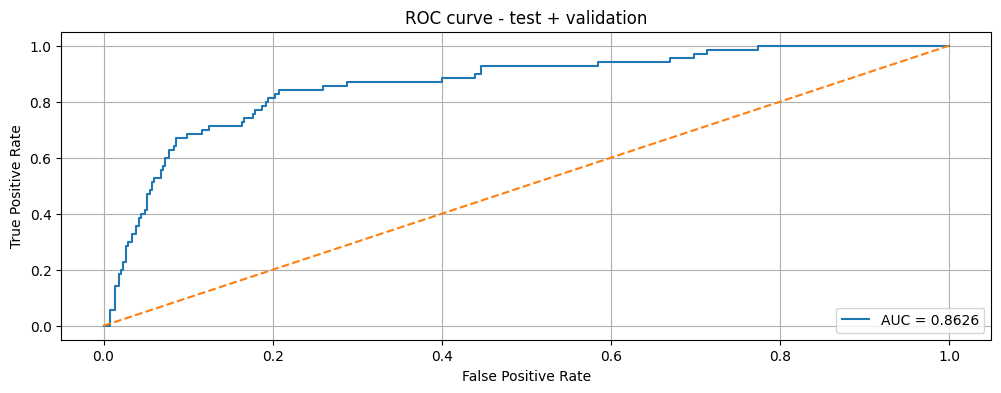

In [23]:

res_train_val = evaluate(best_model_fold, X_test, y_test, set_name="test + validation")

**EXPLICABILIDADE**

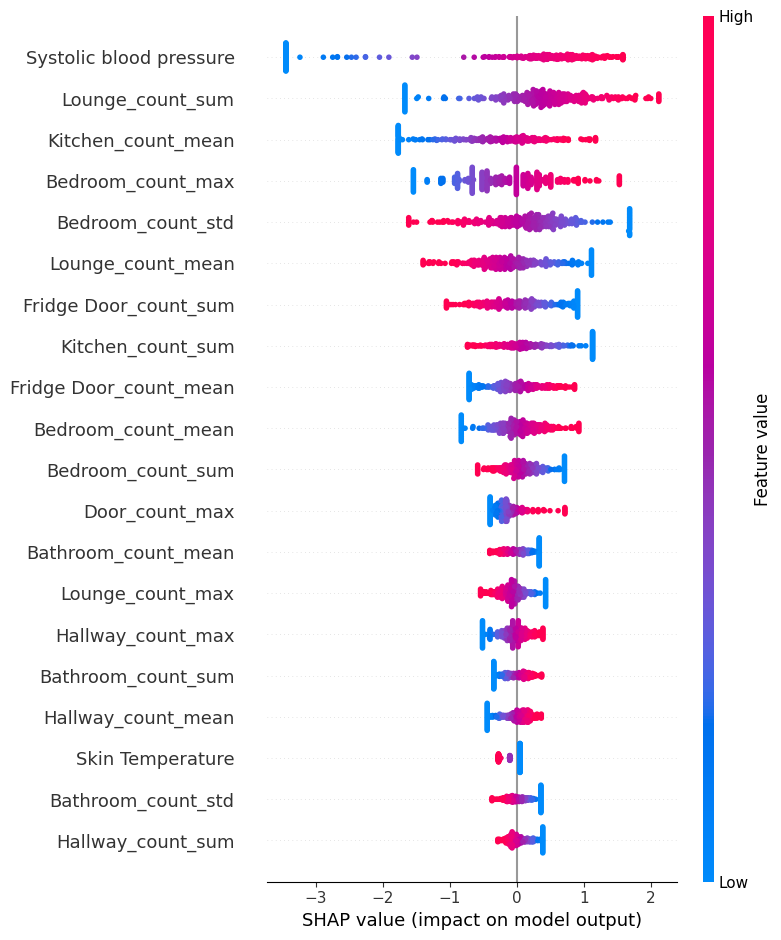

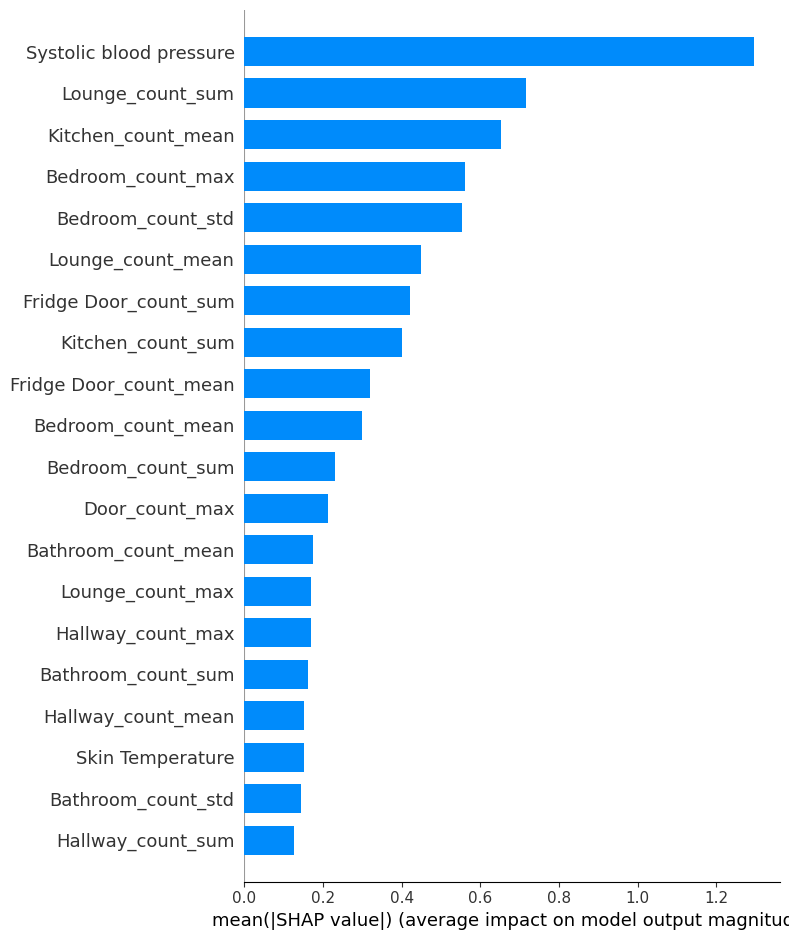

In [24]:
# Amostragem para reduzir custo computacional
import shap
bg = shap.sample(X_train_val_res, 100, random_state=42)  # background (100 exemplos)
X_sample = X_test.sample(n=min(300, len(X_test)), random_state=42)  # amostra de explicação

# Criação do LinearExplainer (suitable for linear models like Logistic Regression)
explainer = shap.LinearExplainer(
    best_model_fold.named_steps['rl'] if hasattr(best_model_fold, 'named_steps') else best_model_fold,
    masker=shap.maskers.Independent(data=bg), # Add the masker argument
    model_output="probability"
)

# Cálculo dos valores SHAP
shap_values = explainer.shap_values(X_sample)

# Summary plot
plt.figure()
shap.summary_plot(shap_values, X_sample, show=False)
plt.tight_layout()
plt.show()

# Bar plot
plt.figure()
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

**TREINANDO MODELO NO CONJUNTO DE TODOS OS DADOS**

In [25]:
# Concatenate train, validation, and test sets
X_train_val_test = pd.concat([X_train, X_val, X_test], ignore_index=True)
y_train_val_test = pd.concat([y_train, y_val, y_test], ignore_index=True)

# Aplicar SMOTE no conjunto X_train_val_test
X_res, y_res = smote.fit_resample(X_train_val_test, y_train_val_test)

search.fit(X_res, y_res)
best_model_fold = search.best_estimator_

print("Best hyperparameters found in this fold:", search.best_params_)
print("Best F1 score on inner CV:", search.best_score_)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Best hyperparameters found in this fold: {'C': np.float64(1.563740674119393), 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 score on inner CV: 0.6442847766768441



-------------------------------------------- Avaliação no test + validation -------------------------------------------

Accuracy: 0.6417582417582418

Classification report:
               precision    recall  f1-score   support

           0     0.9664    0.5974    0.7384       385
           1     0.2857    0.8857    0.4321        70

    accuracy                         0.6418       455
   macro avg     0.6261    0.7416    0.5852       455
weighted avg     0.8617    0.6418    0.6912       455

Confusion matrix:
 [[230 155]
 [  8  62]]

ROC AUC: 0.8601855287569574


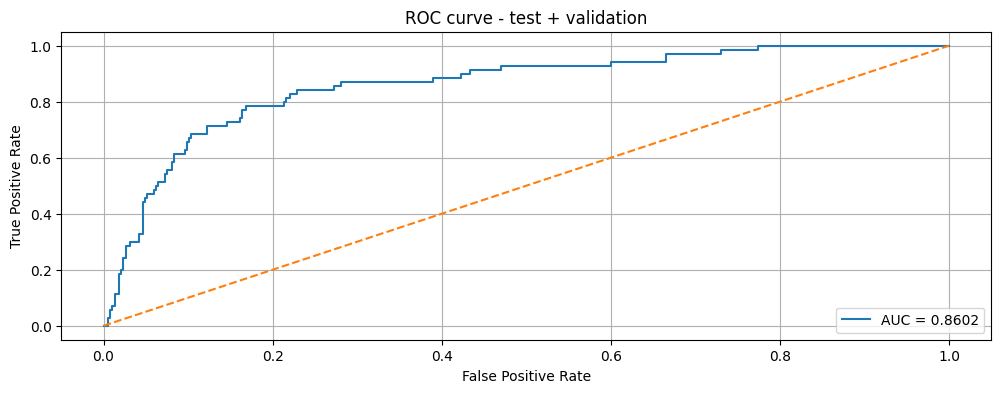

In [26]:

res_train_val = evaluate(best_model_fold, X_test, y_test, set_name="test + validation + treino")

In [27]:
import pickle

# Save the model
filename = '/content/drive/MyDrive/MESTRADO/CMP Aprendizado de Máquina/TRABALHO/DADOS ESSE/best_rl_model.pkl'
pickle.dump(best_model_fold, open(filename, 'wb'))

print(f"Model saved to {filename}")

Model saved to /content/drive/MyDrive/MESTRADO/CMP Aprendizado de Máquina/TRABALHO/DADOS ESSE/best_rl_model.pkl
